In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
36981,NaN,NaN,International,2020-03-01,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36982,NaN,NaN,International,2020-03-02,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36983,NaN,NaN,International,2020-03-10,696.0,-9.0,7.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


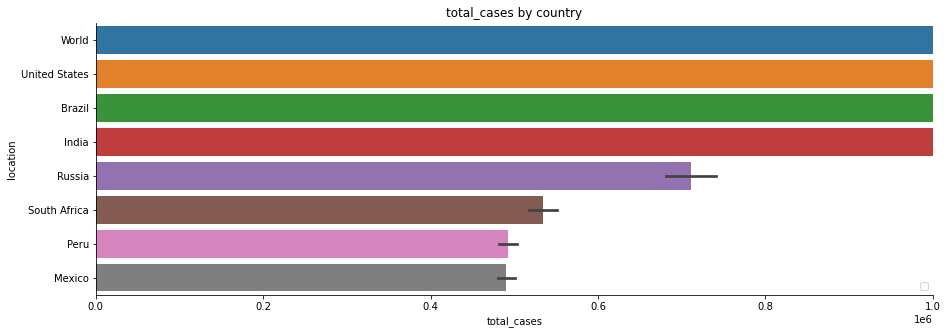

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


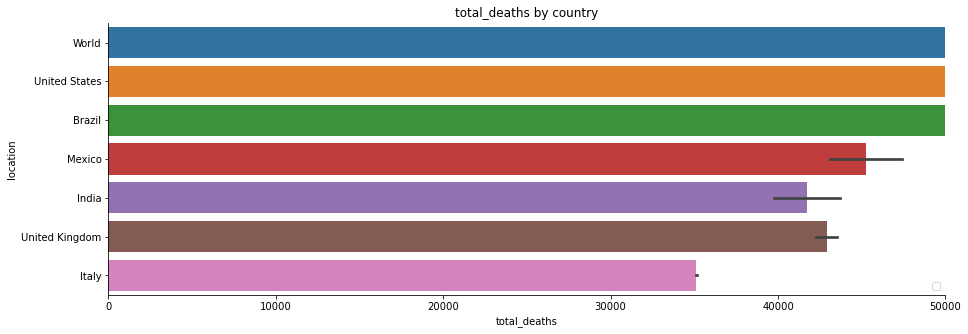

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


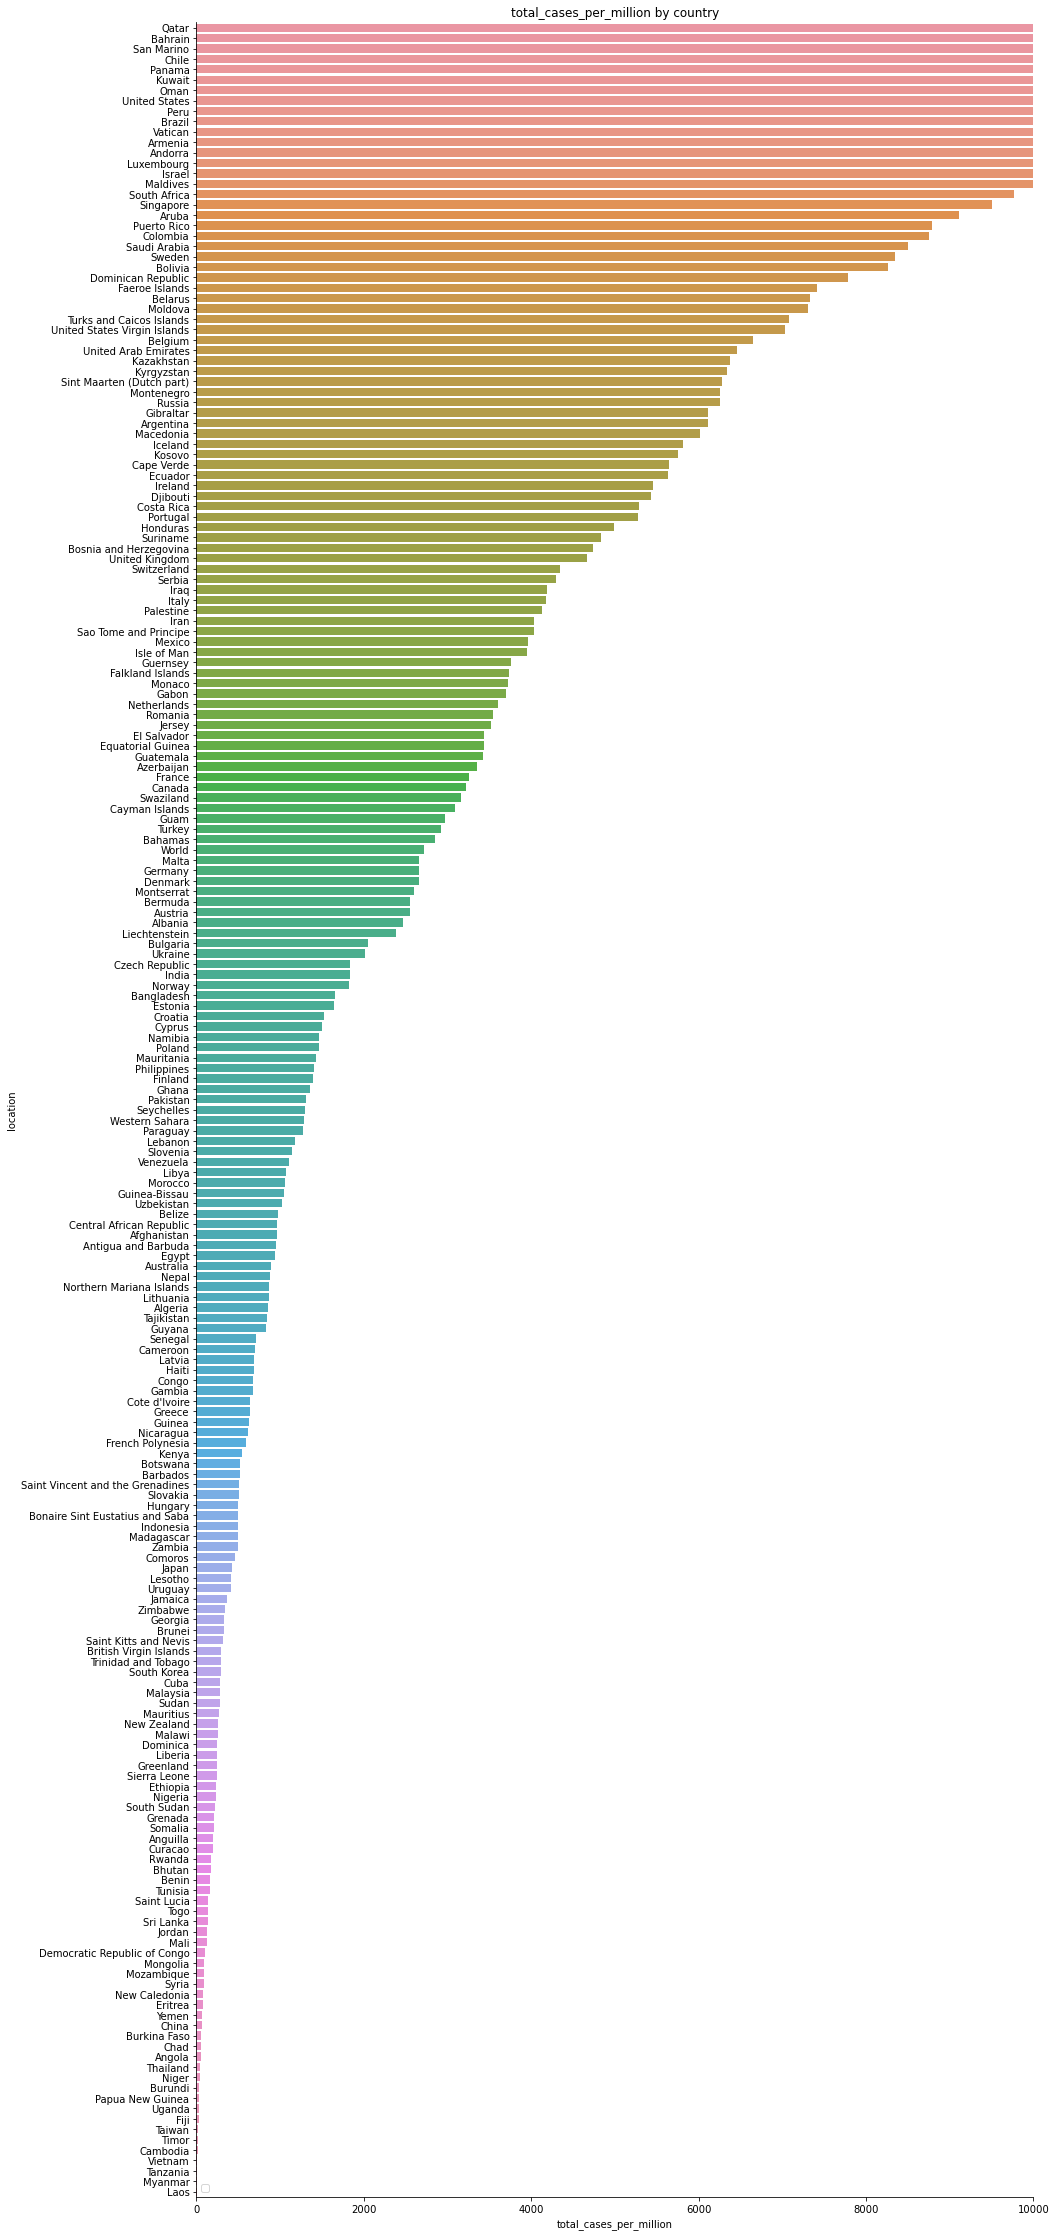

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


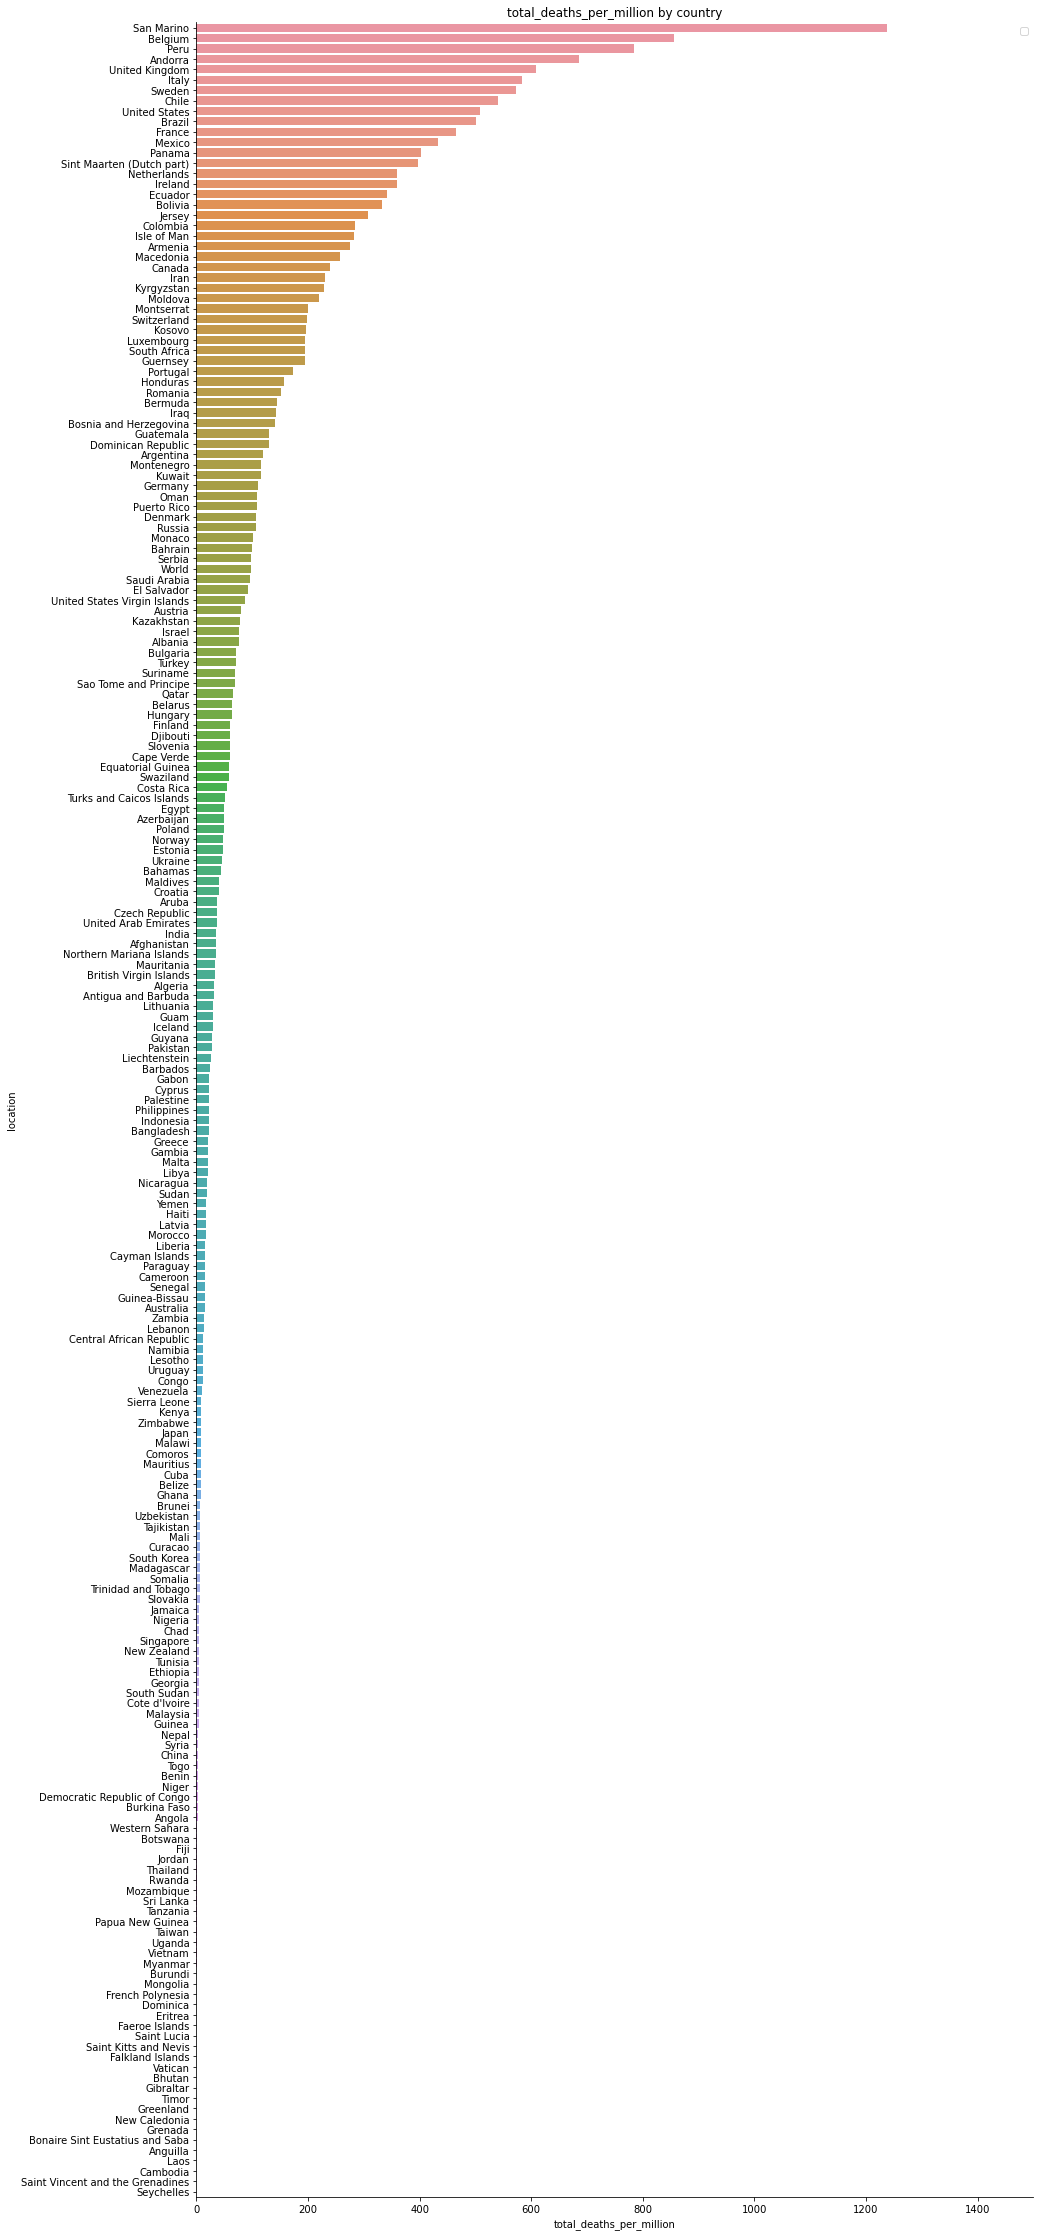

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

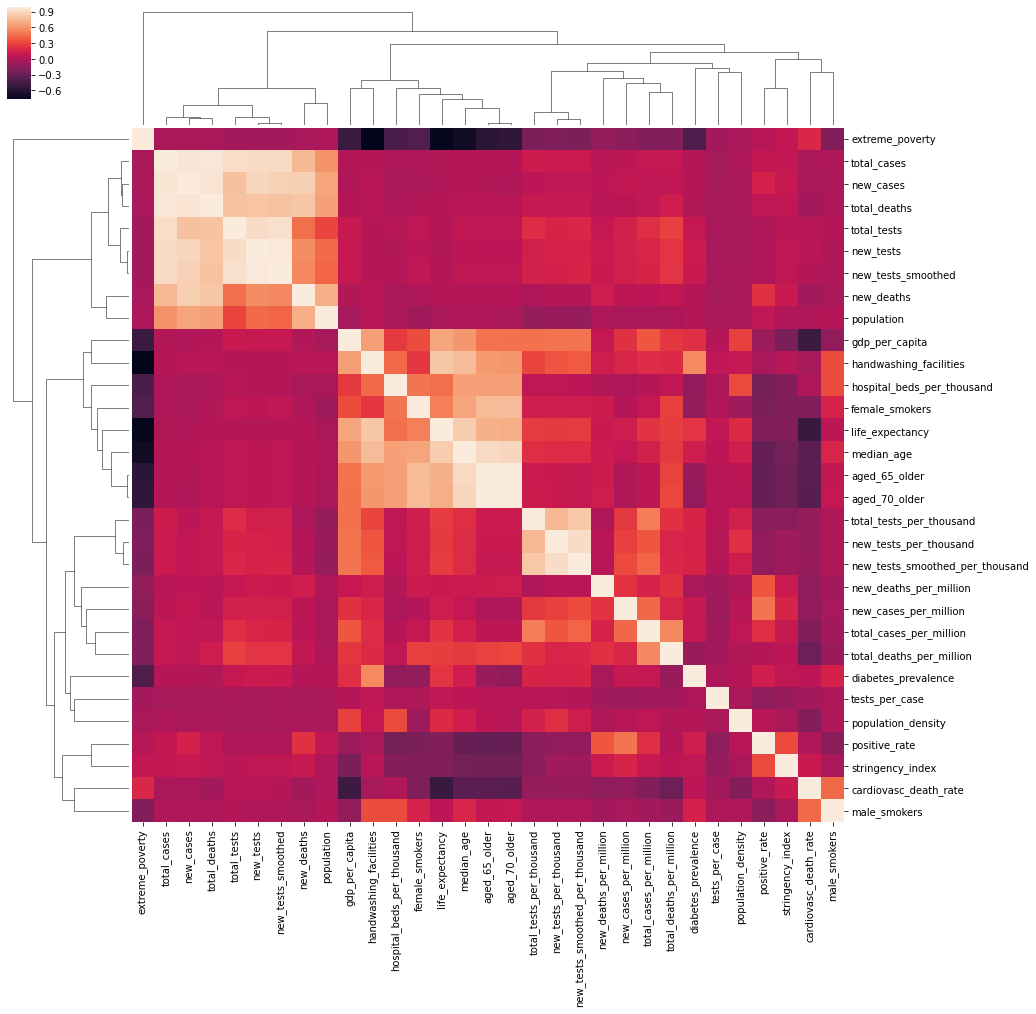

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996430271014796 (+/- 0.00020509637593256626)
Coef :  [1.04366365e+00 8.12662454e-05 8.56564546e-05]
3 Last_days :  [[20638713 20924975 21213649]]
Today :  21213649
Prediction + :  393582
Tomorow :  21607231
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995695267665209 (+/- 2.326806812785345e-05)
Coef :  [-0.11206903  0.5421625   0.57953525]
3 Last_days :  [[749641 754177 760421]]
Today :  760421
Prediction + :  7217
Tomorow :  767638
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.978340331020024 (+/- 0.020622957280132047)
Coef :  [-0.67237245  0.73470556  0.93836502]
3 Last_days :  [[206696 209365 212211]]
Today :  212211
Prediction + :  2083
Tomorow :  214294
                                     
--------- Total Death -----------------
                                     
R^2: 0.4209194547235376 (+/- 0.8026215575478816)
Coef :  [-0.75598725  0.78825937  0.96687551]
3 Last_days :  [[30371 30388 30406]]
Today :  30406
Prediction + :  37
Tomorow :  30443
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7637839542124133 (+/- 0.17382073013856134)
Coef :  [-0.32086268 -0.02665455  1.34178899]
3 Last_days :  [[89045 89144 89214]]
Today :  89214
Prediction + :  73
Tomorow :  89287
                                     
--------- Total Death -----------------
                                     
R^2: -1685.9670649150466 (+/- 2385.3714567649868)
Coef :  [-0.07647769  0.01240981  1.05615197]
3 Last_days :  [[4697 4700 4701]]
Today :  4701
Prediction + :  7
Tomorow :  4708
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.774439013686056 (+/- 0.317368196156075)
Coef :  [-0.83914384  0.90577379  0.93258518]
3 Last_days :  [[251713 252235 252809]]
Today :  252809
Prediction + :  567
Tomorow :  253376
                                     
--------- Total Death -----------------
                                     
R^2: 0.9468289254714767 (+/- 0.053906853444809597)
Coef :  [-0.83786983  0.90463278  0.93245274]
3 Last_days :  [[35225 35231 35234]]
Today :  35234
Prediction + :  27
Tomorow :  35261
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6054957138471225 (+/- 0.5463181664113447)
Coef :  [-0.7467437   0.77397718  0.97336596]
3 Last_days :  [[329784 337334 342813]]
Today :  342813
Prediction + :  6076
Tomorow :  348889
                                     
--------- Total Death -----------------
                                     
R^2: -0.6336286672024753 (+/- 1.1395409658022742)
Coef :  [-0.71546578  0.60444034  1.11003994]
3 Last_days :  [[28579 28605 28617]]
Today :  28617
Prediction + :  29
Tomorow :  28646
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9963053500949087 (+/- 0.004852841470891562)
Coef :  [0.08739193 0.4621645  0.4712146 ]
3 Last_days :  [[5197148 5248242 5313080]]
Today :  5313080
Prediction + :  80406
Tomorow :  5393486
                                     
--------- Total Death -----------------
                                     
R^2: 0.49316659277686975 (+/- 0.7149140910357812)
Coef :  [-0.65116895  0.77783953  0.87546305]
3 Last_days :  [[166027 167110 168446]]
Today :  168446
Prediction + :  1127
Tomorow :  169573
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9962467355021115 (+/- 0.003704058696322694)
Coef :  [-0.78535586  0.87884909  0.90662722]
3 Last_days :  [[313798 314927 316367]]
Today :  316367
Prediction + :  1212
Tomorow :  317579
                                     
--------- Total Death -----------------
                                     
R^2: 0.3637963792131793 (+/- 0.6948141278995278)
Coef :  [-0.78309067  0.70513475  1.07610437]
3 Last_days :  [[46706 41347 41357]]
Today :  41357
Prediction + :  -4227
Tomorow :  37130
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9928000534479794 (+/- 0.00824134633206377)
Coef :  [-0.81667274  0.86834915  0.94790421]
3 Last_days :  [[219964 221413 222828]]
Today :  222828
Prediction + :  1303
Tomorow :  224131
                                     
--------- Total Death -----------------
                                     
R^2: 0.453042041407627 (+/- 0.7603190877809127)
Coef :  [-0.7983852   0.84304179  0.95478946]
3 Last_days :  [[9211 9225 9231]]
Today :  9231
Prediction + :  18
Tomorow :  9249
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4262050490708294 (+/- 0.8109972745126286)
Coef :  [0.14593566 0.43467324 0.43254661]
3 Last_days :  [[333699 336324 338825]]
Today :  338825
Prediction + :  3761
Tomorow :  342586
                                     
--------- Total Death -----------------
                                     
R^2: 0.8848987346622715 (+/- 0.1624295389551213)
Coef :  [-0.0733902   0.54722554  0.54023192]
3 Last_days :  [[18988 19162 19331]]
Today :  19331
Prediction + :  241
Tomorow :  19572
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9987931781094185 (+/- 0.0014606971320957074)
Coef :  [-0.7649436   0.86081837  0.90129734]
3 Last_days :  [[244392 245635 246861]]
Today :  246861
Prediction + :  1092
Tomorow :  247953
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995457842359058 (+/- 0.0003115521933194852)
Coef :  [-0.82656227  0.90225879  0.92133222]
3 Last_days :  [[5891 5912 5934]]
Today :  5934
Prediction + :  19
Tomorow :  5953
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4687573739800865 (+/- 0.7488139985710008)
Coef :  [-0.17228231  0.48657804  0.70554204]
3 Last_days :  [[3164785 3224876 3275520]]
Today :  3275520
Prediction + :  63854
Tomorow :  3339374
                                     
--------- Total Death -----------------
                                     
R^2: 0.5105927763473802 (+/- 0.6872463892882539)
Coef :  [-0.21825081  0.56098161  0.67085385]
3 Last_days :  [[104201 105463 106523]]
Today :  106523
Prediction + :  1553
Tomorow :  108076
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(21213649, 760421, 21607231, 767638),
 (212211, 30406, 214294, 30443),
 (252809, 35234, 253376, 35261),
 (342813, 28617, 348889, 28646),
 (5313080, 168446, 5393486, 169573),
 (89214, 4701, 89287, 4708),
 (316367, 41357, 317579, 37130),
 (222828, 9231, 224131, 9249),
 (338825, 19331, 342586, 19572),
 (246861, 5934, 247953, 5953),
 (3275520, 106523, 3339374, 108076)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-15,France,214294.0,0.0,30443.0,0.0,0.0,0.0
0,2020-08-15,China,89287.0,0.0,4708.0,0.0,0.0,0.0
0,2020-08-15,Italy,253376.0,0.0,35261.0,0.0,0.0,0.0
0,2020-08-15,Spain,348889.0,0.0,28646.0,0.0,0.0,0.0
0,2020-08-15,United States,5393486.0,0.0,169573.0,0.0,0.0,0.0
0,2020-08-15,World,21607231.0,0.0,767638.0,0.0,0.0,0.0
0,2020-08-15,United Kingdom,317579.0,0.0,37130.0,0.0,0.0,0.0
0,2020-08-15,Germany,224131.0,0.0,9249.0,0.0,0.0,0.0
0,2020-08-15,Iran,342586.0,0.0,19572.0,0.0,0.0,0.0
0,2020-08-15,Turkey,247953.0,0.0,5953.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")